# Geospatial Data
## In This Lesson
* Geospatial Fundamentals
* Folium
* Distances
* Map Projections
* British National Grid
* Shapefiles

# What is Geospatial Data?

Quite simply, geospatial data is data which contains information about a physical location on the Earth.

A simple example of geospatial data you might encounter could be the results of an API call, asking for locations of cities. It could look something like this:

In [16]:

api_response = {
    "cities": [
        {
            "name": "London",
            "location": {
                "lat": 51.509865,
                "lon": -0.118092
            }
        },
        {
            "name": "Manchester",
            "location": {
                "lat": 53.483959,
                "lon": -2.244644
            }
        },
        {
            "name": "Milton Keynes",
            "location": {
                "lat": 52.0406, 
                "lon": -0.7594
            }
        }
    ]
}


Here, the "lat" (latitude) and "lon" (longitude) values for each city specify their locations.

# Folium

Next, we might want to visualise these cities on a map. There are many different ways to visualise locations in Python, my personal preference is a library called Folium (a wrapper for the Leaflet Javascript library).

To install Folium, simply run


In [ ]:
!pip install folium

Once folium is up and running, we can show a map centred on our first city (London).

In [17]:

import folium

london_location = api_response["cities"][0]["location"]

m = folium.Map(location=[london_location["lat"], london_location["lon"]])

m


Note, the map is interactive, allowing you to zoom in and out, and drag your view around.

Plotting each of our cities as markers with Folium is also simple, see below

In [31]:

m = folium.Map(location=[london_location["lat"], london_location["lon"]], zoom_start=6)

for city in api_response["cities"]:
    folium.Marker([city["location"]["lat"], city["location"]["lon"]], tooltip=city["name"]).add_to(m)
    
m


I will run through some other capabilities of Folium during the lesson. For a full breakdown and tutorial for all functionality in Folium, see [the quickstart](https://python-visualization.github.io/folium/quickstart.html).

In [ ]:
# Note, I am simply placing m at the bottom of each cell to display the maps in a notebooks environment.
# You can also save the maps as flat files, either when outside of notebooks or when producing an output for a customer.
# e.g.
# m.save("index.html")

# Projections & Distances

A common question we might ask of geospatial points, is for the distance between them. For example, what is the distance between London and Manchester?

Because latitudes and longitudes are points on the surface of a sphere, they are measured in degrees - a unit of angles, not distances. Therefore, working out the distance between them is quite complicated. We want to calculate, what is known as the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). Fortunately, one of the great benefits of python is that there is a library for most things, to calculate the Haversine distance we can simply

In [12]:
!pip install haversine

Then use the haversine library to calculate the distance:

In [20]:

import haversine as hs

manchester_location = api_response["cities"][1]["location"]

distance = hs.haversine(
    (manchester_location["lat"], manchester_location["lon"]),
    (london_location["lat"], london_location["lon"]),
                       )

print("The distance from London to Manchester is {:.2f} km.".format(distance))

The distance from London to Manchester is 262.48 km.


([Source](https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b))

Something like the Haversine library is great for quickly calculating distances between simple points, but working with latitudes and longitudes can become increasingly complicated when we start working with more complicated geospatial objects, such as areas.

Fortunately, latitudes and longitudes are not the only way to express geolocations. If we use a Euclidean coordinate system, then we can calculate distances as if we have points on a flat surface (i.e. not a sphere).

When working with locations in the UK, we can work with a coordinate system called the "British National Grid".

<a title="File:British National Grid.svg: *National_Grid_for_Great_Britain_with_central_meridian.gif: *National_Grid_for_Great_Britain_with_central_meridian.png: MansLaughter (talk)
derivative work: MansLaughter (talk)
United_Kingdom_and_North-West_France.svg: *Europe_blank_laea_location_map.svg: Alexrk2 from naturalearthdata data
derivative work: Pethrus (talk)
derivative work: nandhp (talk)
derivative work: Kognos, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:British_National_Grid_Letters_and_Numbers.png"><img width="256" alt="British National Grid Letters and Numbers" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/British_National_Grid_Letters_and_Numbers.png/256px-British_National_Grid_Letters_and_Numbers.png"></a>

The British National Grid (BNG) measures coordinates from a point in the Atlantic Ocean, at the bottom left of the above image.

The distance east from that point, in meters, traveling along the surface of the Earth is called the "Easting".

The distance north from that point, in meters, traveling along the surface of the Earth is called the "Northing".

Together, eastings and northings can be used to identify any point in the United Kingdom. Distances between BNG coordinates can be calculated using [Pythagoras' Theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem), as we can consider the surface flat.

To convert from latitudes and longitudes (known as the WGS84 projection) to BNG coordinates, we can use the [pyproj](https://pyproj4.github.io/pyproj/stable/) library.

In [19]:
!pip install pyproj

In [21]:

from pyproj import Transformer

# First define the EPSG numbers for our projection systems
wgs84_id = "epsg:4326"
bng_id = "epsg:27700"

# Define a transformer
transformer = Transformer.from_crs(wgs84_id, bng_id)

# Use the transformer
london_bng = transformer.transform(london_location["lat"], london_location["lon"])
manchester_bng = transformer.transform(manchester_location["lat"], manchester_location["lon"])

print("London Easting & Northing:")
print(london_bng)
print("Manchester Easting & Northing:")
print(manchester_bng)


London Easting & Northing:
(530695.386831743, 180671.4883862415)
Manchester Easting & Northing:
(383862.99257143016, 398610.2306350315)


To demonstrate that this is working correctly, we can calculate the distance between the London and Manchester British National Grid coordinates using g Pythagoras' Theorem.

In [26]:

distance_pythag = (
                    (london_bng[0] - manchester_bng[0]) ** 2 +
                    (london_bng[1] - manchester_bng[1]) ** 2
                  ) ** 0.5

# The value will be in meters, divide by 1000 for the answer in kilometres 
print("The distance from London to Manchester is {:.2f} km.".format(distance_pythag/1000))

The distance from London to Manchester is 262.79 km.


As you can see, this method gives us the same (or certainly a very close) distance as when using the Haversine method.

# Shapefiles
Commonly, in business, you will find yourself working with shapefiles for geospatial data.

For example, we will look at some shapefiles published by UK water utilities. The UK water regulator, requires all water companies to detail their supply area in shapefile format, links can be found [here](https://www.ofwat.gov.uk/regulated-companies/markets/water-bidding-market/water-resources-market-information/)

For convenience, I have downloaded the Anglian Water shapefile for Ruthamford Central into this git repo. It is also available [on the Anglian Water website](https://www.anglianwater.co.uk/about-us/our-strategies-and-plans/water-resources-management-plan/water-resources-market-information/tables-and-zones/).

Shapefiles are typically used in GIS Software, however, we can also work with them in Python. I recommend using [PyShp](https://pypi.org/project/pyshp/) to read shapefiles.

In [1]:
!pip install pyshp

In [8]:

import shapefile

# Note, there are multiple files in the ruthamford_central_shapefile directory
# This is normal, there is no need for us to specify the file extension to read the shapefile
sf = shapefile.Reader("../data/ruthamford_central_shapefile/AW_WRZ_Dec16_RTC_RutCentral")


Shapefiles contain both shapes, and records, shapes are associated with records we can loop through them together:

In [9]:
for sr in sf.shapeRecords():
    print(sr.shape)
    print(sr.record)

Record #-1: [1, 231325.289138, 719912801.764, 'Ruthamford Central', 'RTC', 0, 1, 1]


We can see, this shapefile contains only one shape and it's associated record, the shape for Ruthamford Central. Let's just pull out the shape itself.

In [10]:
ruthamford_central = sf.shapes()[0]
print(ruthamford_central)

A shape object is fundamentally a list of points, we can view the first few of these to see that they are a list of tuples, and that they are in British National Grid Coordinates.

In [13]:
print(ruthamford_central.points[:5])

[(489630.6190000009, 257482.8227000013), (489678.79899999965, 257388.5217000004), (489689.5050000008, 257375.75569999963), (489696.506000001, 257369.57970000245), (489704.32999999914, 257367.52070000023)]


It is quite common for public data sets in the United Kingdom to be published in BNG coordinates.

With our data in BNG, we can easily ask questions, relating to other BNG coordinates, for example, if they are contained within the shape. To do this, we are going to use the [shapely](https://shapely.readthedocs.io/en/stable/manual.html) library.

In [24]:
! pip install shapely

In [25]:

# First get the location of Milton Keynes in BNG coordinates
mk_location = api_response["cities"][2]["location"]
mk_bng = transformer.transform(mk_location["lat"], mk_location["lon"])

# Import the objects we need from shapely, for polygons and points
from shapely.geometry import Polygon, Point

# Create Polygon object
ruthamford_poly = Polygon(ruthamford_central.points)

print("Is Milton Keynes in Ruthamford Central?")
print(ruthamford_poly.contains(Point(mk_bng)))

print("Is Manchester in Ruthamford Central?")
print(ruthamford_poly.contains(Point(manchester_bng)))


Is Milton Keynes in Ruthamford Central?
True
Is Manchester in Ruthamford Central?
False


Or, if a line intersects the polygon

In [27]:

from shapely.geometry import LineString

london_to_manchester = LineString([london_bng, manchester_bng])

print("Does the line from London to Manchester cross Ruthamford Central?")
print(london_to_manchester.intersects(ruthamford_poly))


Does the line from London to Manchester corss Ruthamford Central?
True


It's important to remember that Shapely assumes a Euclidean geometry, so these checks will only work in BNG coordinates.

These checks would not work correctly in latitudes and longitudes as they are measurements in degrees for points on the surface of a sphere.

We can easily verify the checks are correct by plotting the coordinates in [matplotlib](https://matplotlib.org/).

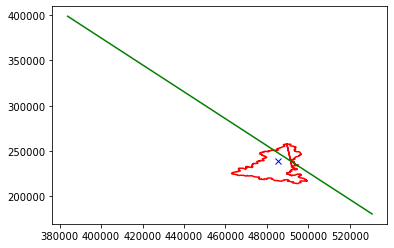

In [30]:

import matplotlib.pyplot as plt

# Extract the coordinates as a list of x and y for plotting
ruthamford_x, ruthamford_y = ruthamford_poly.exterior.xy

# Plot polygon
plt.plot(ruthamford_x, ruthamford_y, c="red")

# Plot Milton Keynes
plt.plot(mk_bng[0], mk_bng[1], "bx")

# Plot London to Manchester
lm_x, lm_y = london_to_manchester.xy
plt.plot(lm_x, lm_y, c="green")

# Visualise
plt.show()



Above, we can see that the blue cross for Milton Keyes does sit inside the polygon, and the green line from London to Manchester also crosses it.

Here we can also see a limitation of using matplotlib for this, the axes are warped and there is no wider geographical context. While it is possible to add these things in with matplotlib, it would be far easier to use Folium. For this, we must convert the polygon into a WGS84 (latitudes and longitudes) projection.


In [46]:

# Define a transformer
reverse_transformer = Transformer.from_crs(bng_id, wgs84_id)

# Produce the list of WGS84 points
# (Note the [::-1] operator to reverse the order of coordinates)
# If you get latitudes and longitudes the wrong way round (in the UK), points will appear just East of Somalia
wgs_points = [reverse_transformer.transform(*p)[::-1] for p in ruthamford_central.points]

# Make our WGS84 ploygon
wgs_poly = Polygon(wgs_points)

# Create Folium Map
m = folium.Map(location=[london_location["lat"], london_location["lon"]], zoom_start=8)

# Add Polygon
folium.GeoJson(wgs_poly).add_to(m)

# Add point for Milton Keynes
folium.Marker([mk_location["lat"], mk_location["lon"]], tooltip="Milton Keynes").add_to(m)

# Add a line between London and Manchester
folium.PolyLine(
    [
        [london_location["lat"], london_location["lon"]],
        [manchester_location["lat"], manchester_location["lon"]]
    ], 
    tooltip="London to Manchester"
).add_to(m)

# Done
m


# Recap

* Why is Folium useful?
* What are the differences between latitudes/longitudes and eastings/northings?
* When is each type of projection most appropriate?
* How do you calculate a distance between two points?
* Which Python libraries can help us process geospatial data?

# Homework

Take a look at the [TFL Open Data](https://tfl.gov.uk/info-for/open-data-users/our-open-data?intcmp=3671). Download and visualise data for cycle hire stations in London. Then explore the capabilities of Folium to layer on additional information.

Possible ideas:
* Change the Folium tile set to a satellite or greyscale view
* Rank cycle stations by how close they are to their nearest Tube Station using the Haversine distance
* Categorise and colour code cycle stations by which areas (e.g. parliamentary constituency) they are in
* Add pop-ups to cycle stations when clicked to provide usage statistics